In [1]:
import pandas as pd
import numpy as np
import pmdarima as pm
import statsmodels.api
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from fbprophet import Prophet
import math

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
#russia dataset

In [3]:
xls = pd.ExcelFile('2020Q1Q2Q3Q4-2021Q1.xlsx')
df_russia = pd.read_excel(xls, 'Russia - Sberbank Rossii PAO (S')
#df2 = pd.read_excel(xls, 'Sheet2')

In [4]:
df_russia.shape

(312, 7)

In [5]:
df_russia.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,291.02,294,294.42,290.26,47.00M,-0.0076
1,2021-03-30 00:00:00,293.25,294.86,295.72,291.5,38.81M,-0.0002
2,2021-03-29 00:00:00,293.3,289.72,294.09,289.26,43.68M,0.0071
3,2021-03-26 00:00:00,291.22,288.63,292.75,288.32,56.07M,0.0159
4,2021-03-25 00:00:00,286.66,286.5,287.03,283.85,35.22M,0.0030


In [6]:
#Rename the Vol. column to Volume
df_russia.rename(columns = {'Vol.': 'Volume'}, inplace = True)

In [7]:
df_russia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      312 non-null    object 
 1   Price     312 non-null    object 
 2   Open      312 non-null    object 
 3   High      312 non-null    object 
 4   Low       312 non-null    object 
 5   Volume    311 non-null    object 
 6   Change %  311 non-null    float64
dtypes: float64(1), object(6)
memory usage: 17.2+ KB


In [8]:
df_russia.tail()

,Date,Price,Open,High,Low,Volume,Change %
307,2020-01-09 00:00:00,257.99,259.4,261.76,257.01,38.33M,-0.0045
308,2020-01-08 00:00:00,259.15,253.57,259.15,253.03,40.82M,0.0207
309,2020-01-06 00:00:00,253.9,254.75,254.84,251.4,22.35M,-0.0043
310,2020-01-03 00:00:00,255,255.99,258.19,253.7,35.85M,0.0010
311,Highest: 296.07,Lowest: 172.15,Difference: 123.92,Average: 234.52,Change %: 14.24,NaN,NaN


In [9]:
#drop the last row
df_russia.drop(index=df_russia.index[-1], axis=0, inplace=True)
df_russia["Volume"]=df_russia.Volume.str.replace('M','')

In [10]:
df_russia.tail()

,Date,Price,Open,High,Low,Volume,Change %
306,2020-01-10 00:00:00,258.19,257.86,259.25,256.88,18.85,0.0008
307,2020-01-09 00:00:00,257.99,259.4,261.76,257.01,38.33,-0.0045
308,2020-01-08 00:00:00,259.15,253.57,259.15,253.03,40.82,0.0207
309,2020-01-06 00:00:00,253.9,254.75,254.84,251.4,22.35,-0.0043
310,2020-01-03 00:00:00,255,255.99,258.19,253.7,35.85,0.0010


In [11]:
df_russia["Date"]=pd.to_datetime(df_russia.Date,format="%Y-%m-%d")

In [12]:
df_russia=df_russia.astype({'Price':'float','Open':'float','High':'float','Low':'float','Volume':'float'})
print(df_russia.dtypes)

Date        datetime64[ns]
Price              float64
Open               float64
High               float64
Low                float64
Volume             float64
Change %           float64
dtype: object


In [13]:
df_russia.describe()

,Price,Open,High,Low,Volume,Change %
count,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000
mean,234.524019,234.417846,237.314759,231.366141,73.056977,0.000668
std,32.079847,32.058167,32.075624,32.076603,38.058095,0.021931
min,174.270000,175.000000,182.200000,172.150000,8.760000,-0.095700
25%,207.700000,207.215000,209.660000,204.475000,47.670000,-0.010100
50%,229.140000,229.080000,231.950000,226.860000,66.260000,0.000400
75%,264.380000,263.885000,267.255000,261.110000,85.120000,0.012950
max,293.300000,294.860000,296.070000,291.500000,263.040000,0.129000


In [14]:
df_russia.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Volume      0
Change %    0
dtype: int64

In [15]:
#As we can see, there is no missing values. The highest close price over the discussed time is 293.3 and the lowest value is 291.5

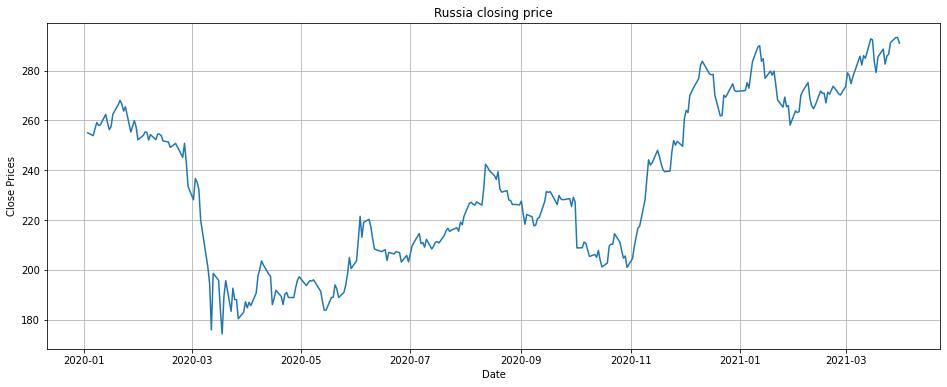

In [16]:
plt.figure(figsize=(16,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_russia['Date'],df_russia['Price'])
plt.title('Russia closing price')
plt.show()

In [17]:
df_russia.head()

,Date,Price,Open,High,Low,Volume,Change %
0,2021-03-31,291.02,294.00,294.42,290.26,47.00,-0.0076
1,2021-03-30,293.25,294.86,295.72,291.50,38.81,-0.0002
2,2021-03-29,293.30,289.72,294.09,289.26,43.68,0.0071
3,2021-03-26,291.22,288.63,292.75,288.32,56.07,0.0159
4,2021-03-25,286.66,286.50,287.03,283.85,35.22,0.0030


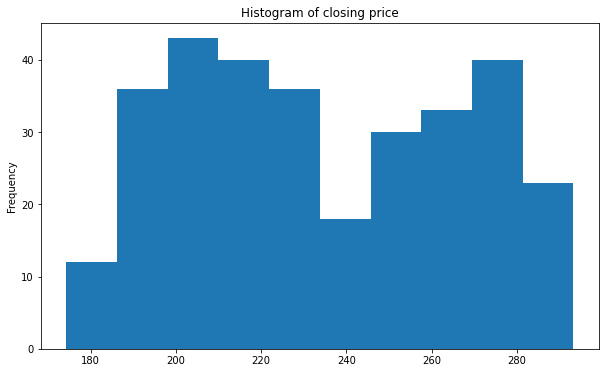

In [18]:
plt.figure(figsize=(10,6))
df_close = df_russia['Price']
df_close.plot(style='k.',kind='hist')
plt.title('Histogram of closing price')
plt.show()

Testing For Stationarity:

To identify the nature of the data, we will be using the null hypothesis.

#Ho: It is non-stationary
#H1: It is stationary
If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear.

In [19]:
df_cpy =df_russia.copy()

In [20]:
#drop Open, Low, High, year and month columns
#df_russia=df_russia.drop(['Open','Low','High'],axis=1)
df_russia.set_index("Date", inplace = True)
df_russia.head()


,Price,Open,High,Low,Volume,Change %
Date,,,,,,
2021-03-31,291.02,294.00,294.42,290.26,47.00,-0.0076
2021-03-30,293.25,294.86,295.72,291.50,38.81,-0.0002
2021-03-29,293.30,289.72,294.09,289.26,43.68,0.0071
2021-03-26,291.22,288.63,292.75,288.32,56.07,0.0159
2021-03-25,286.66,286.50,287.03,283.85,35.22,0.0030


rolling_mean: Date
2021-03-31           NaN
2021-03-30           NaN
2021-03-29           NaN
2021-03-26           NaN
2021-03-25           NaN
2021-03-24           NaN
2021-03-23    289.120000
2021-03-22    288.781429
2021-03-19    287.670000
Name: Price, dtype: float64 

rolling_std: Date
2021-03-31         NaN
2021-03-30         NaN
2021-03-29         NaN
2021-03-26         NaN
2021-03-25         NaN
2021-03-24         NaN
2021-03-23    4.127150
2021-03-22    4.041631
2021-03-19    3.659672
Name: Price, dtype: float64


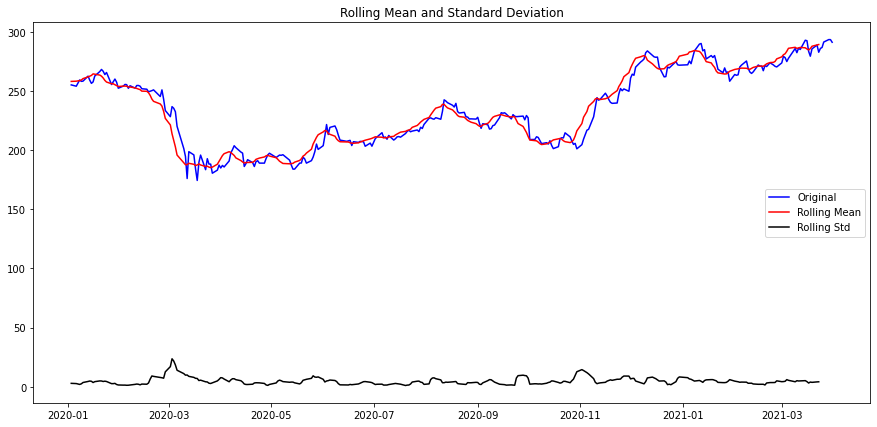

Results of dickey fuller test
Test Statistics                 -1.847182
p-value                          0.357301
No. of lags used                 8.000000
Number of observations used    302.000000
critical value (1%)             -3.452190
critical value (5%)             -2.871158
critical value (10%)            -2.571895
dtype: float64


In [21]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).std()
    print('rolling_mean:', rolmean.head(9),'\n')
    print('rolling_std:', rolstd.head(9))
    #Plot rolling statistics:
    plt.figure(figsize=(15,7))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df_russia['Price'])


In [22]:
#We see that the p-value is greater than 0.05 so we cannot reject the null hypothesis - that the time series is non-stationary and does have time-dependent structure. Also, the test statistics is greater than the critical values. so the data is non-stationary and does have time-dependent structure.

In [23]:
#From non stationary to stationary series
#One method for transforming the simplest non-stationary data is differencing. 
#This process involves taking the differences of consecutive observations.
#For simple distributions, taking the first-order difference.

In [24]:
df_russia["diff_1"] = df_russia.Price.diff(periods=1)
df_russia.head()

,Price,Open,High,Low,Volume,Change %,diff_1
Date,,,,,,,
2021-03-31,291.02,294.00,294.42,290.26,47.00,-0.0076,NaN
2021-03-30,293.25,294.86,295.72,291.50,38.81,-0.0002,2.23
2021-03-29,293.30,289.72,294.09,289.26,43.68,0.0071,0.05
2021-03-26,291.22,288.63,292.75,288.32,56.07,0.0159,-2.08
2021-03-25,286.66,286.50,287.03,283.85,35.22,0.0030,-4.56


In [25]:
results = adfuller(df_russia["diff_1"].dropna())
print('The new p-value is:',results[1])

The new p-value is: 4.3951775754216564e-07


<AxesSubplot:title={'center':'The distribution of the new series'}, xlabel='Date'>

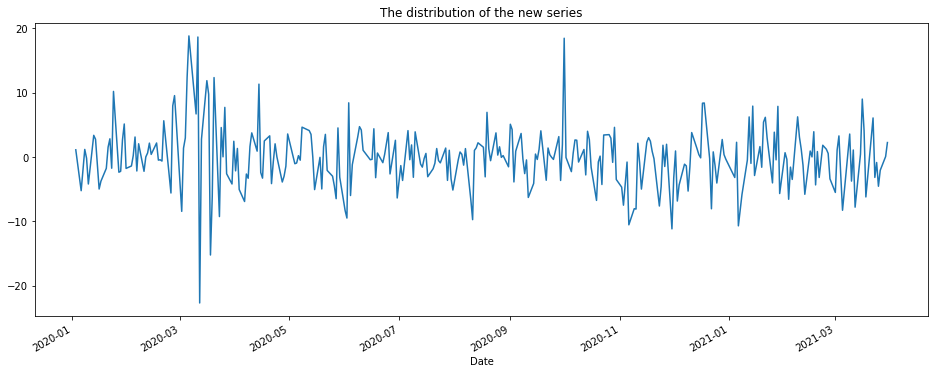

In [26]:
#plot the new series
plt.figure(figsize=(16,6))
plt.title("The distribution of the new series")
df_russia['diff_1'].plot()


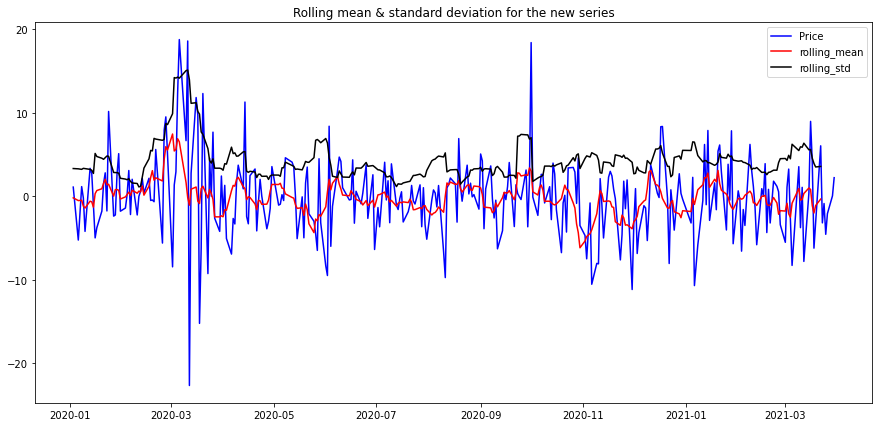

In [27]:
#plot rolling statistics
plt.figure(figsize=(15,7))
orig=plt.plot(df_russia.diff_1, color='blue',label='Price')
R_mean=plt.plot(df_russia.diff_1.rolling(7).mean(), color='red',label='rolling_mean')
R_std=plt.plot(df_russia.diff_1.rolling(7).std(), color='black',label='rolling_std')
plt.legend(loc='best')
plt.title('Rolling mean & standard deviation for the new series')
plt.show(block='False')



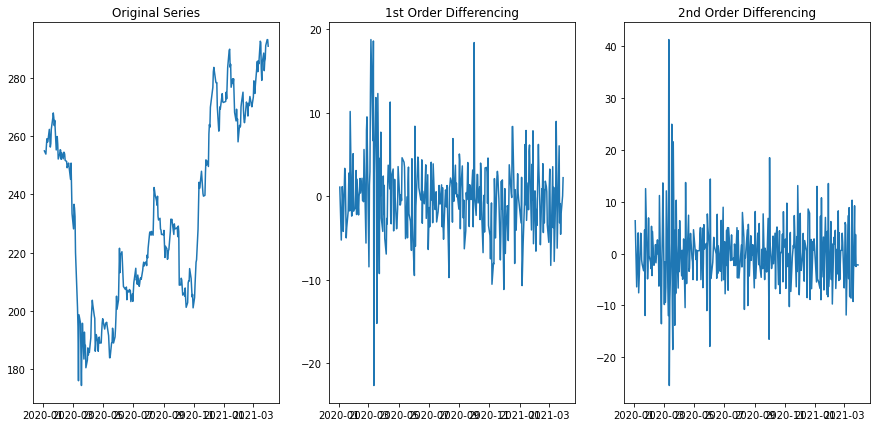

In [28]:
# Original Series
fig, axes = plt.subplots(1, 3, sharex=True,figsize=(15, 7))
axes[0].plot(df_russia.Price)
axes[0].set_title('Original Series')
#plot_acf(df1_russia.Price, ax=axes[0, 1])

# 1st Differencing
axes[1].plot(df_russia.Price.diff())
axes[1].set_title('1st Order Differencing')
#plot_acf(df1_russia.Price.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2].plot(df_russia.Price.diff().diff())
axes[2].set_title('2nd Order Differencing')
#plot_acf(df1_russia.Price.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

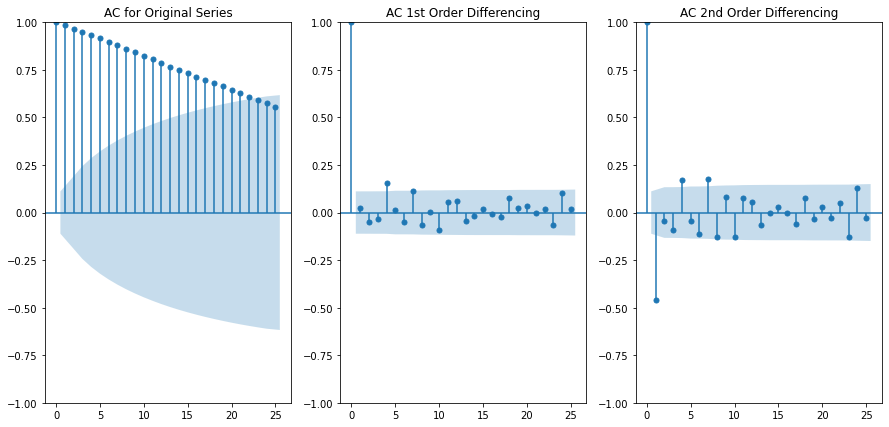

In [29]:
#Plot autocorrelation
# Original Series
fig, axes = plt.subplots(1, 3, sharex=True,figsize=(15, 7))
plot_acf(df_russia.Price, ax=axes[0])
axes[0].set_title('AC for Original Series')

# 1st Differencing
plot_acf(df_russia.Price.diff().dropna(), ax=axes[1])
axes[1].set_title('AC 1st Order Differencing')

# 2nd Differencing
plot_acf(df_russia.Price.diff().diff().dropna(), ax=axes[2])
axes[2].set_title('AC 2nd Order Differencing')

plt.show()

In [30]:
#d=1 ?
#How do we know if there is seasonality?
#how do we decide p,q?

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


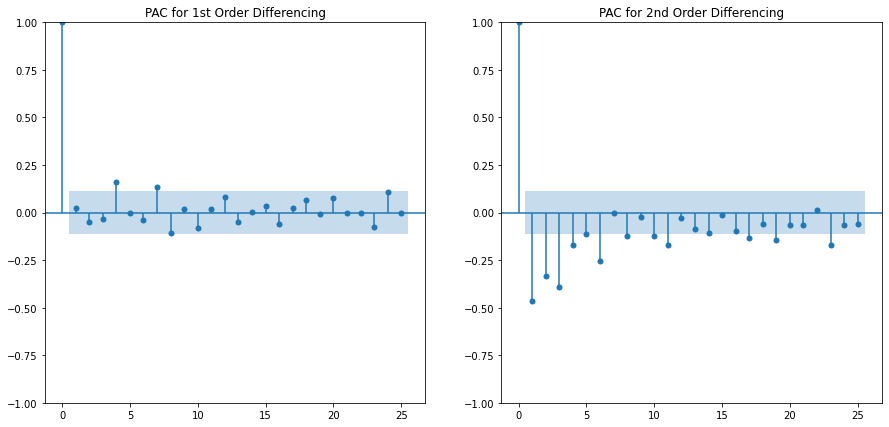

In [31]:
#Plot partial autocorrelation
fig, axes = plt.subplots(1, 2, sharex=True,figsize=(15, 7))
# 1st Differencing
plot_pacf(df_russia.Price.diff().dropna(), ax=axes[0])
axes[0].set_title('PAC for 1st Order Differencing')

# 2nd Differencing
plot_pacf(df_russia.Price.diff().diff().dropna(), ax=axes[1])
axes[1].set_title('PAC for 2nd Order Differencing')

plt.show()

In [32]:
#split the data
train_rus = df_russia[df_russia.index < pd.to_datetime('2021-01-01', format="%Y-%m-%d")]
train_rus = train_rus.dropna()
test_rus = df_russia[df_russia.index >= pd.to_datetime('2021-01-01', format="%Y-%m-%d")]
test_rus = test_rus.dropna()

In [33]:
train_rus.index.max()

Timestamp('2020-12-30 00:00:00')

In [34]:
test_rus.head()

,Price,Open,High,Low,Volume,Change %,diff_1
Date,,,,,,,
2021-03-30,293.25,294.86,295.72,291.50,38.81,-0.0002,2.23
2021-03-29,293.30,289.72,294.09,289.26,43.68,0.0071,0.05
2021-03-26,291.22,288.63,292.75,288.32,56.07,0.0159,-2.08
2021-03-25,286.66,286.50,287.03,283.85,35.22,0.0030,-4.56
2021-03-24,285.79,283.40,288.00,282.25,46.41,0.0113,-0.87


In [35]:
train_rus.index.min()

Timestamp('2020-01-03 00:00:00')

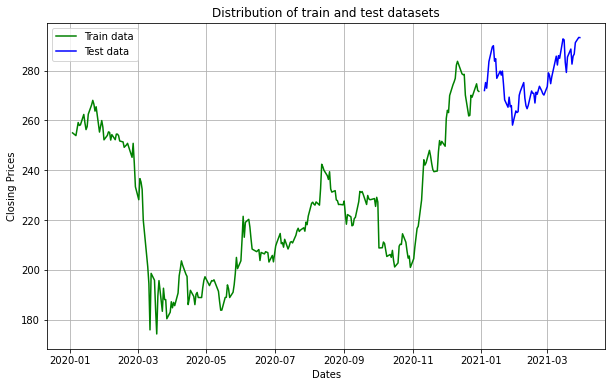

In [36]:
#plot the distribution of train and test
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_rus.Price, 'green', label='Train data')
plt.plot(test_rus.Price, 'blue', label='Test data')
plt.title('Distribution of train and test datasets')
plt.legend()

In [37]:
arima_model = pm.auto_arima(train_rus['Price'].sort_index(), start_p=1, start_q=1, test='adf', max_p=6, max_q=6, 
                      m=1, d=None, seasonal=False, start_P=0, D=1, trace=False, error_action='ignore',  
                      suppress_warnings=True, stepwise=False)

In [38]:
y_pred = arima_model.predict(len(test_rus['Price']))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [39]:
y_pred

250    272.015074
251    273.077896
252    271.712241
253    272.763563
254    272.654947
255    272.261564
256    272.977076
257    272.602780
258    272.742151
259    273.020721
260    272.793100
261    273.056766
262    273.093106
263    273.061800
264    273.261494
265    273.239761
266    273.318566
267    273.430078
268    273.436204
269    273.542107
270    273.603577
271    273.649304
272    273.743095
273    273.791935
274    273.860399
275    273.936411
276    273.990507
277    274.064851
278    274.130534
279    274.192611
280    274.264678
281    274.327627
282    274.394394
283    274.462880
284    274.526813
285    274.594851
286    274.661207
287    274.726747
288    274.794360
289    274.860126
290    274.926633
291    274.993526
292    275.059475
293    275.126255
294    275.192709
295    275.258981
296    275.325682
297    275.392010
298    275.458481
299    275.525038
300    275.591399
301    275.657928
302    275.724395
303    275.790821
304    275.857336
305    275

In [40]:
test_new = test_rus.sort_index()

In [41]:
test_new['Pred'] = y_pred.values

In [42]:
test_rus.head()

,Price,Open,High,Low,Volume,Change %,diff_1
Date,,,,,,,
2021-03-30,293.25,294.86,295.72,291.50,38.81,-0.0002,2.23
2021-03-29,293.30,289.72,294.09,289.26,43.68,0.0071,0.05
2021-03-26,291.22,288.63,292.75,288.32,56.07,0.0159,-2.08
2021-03-25,286.66,286.50,287.03,283.85,35.22,0.0030,-4.56
2021-03-24,285.79,283.40,288.00,282.25,46.41,0.0113,-0.87


In [43]:
def actual_prediction_plot(actual, prediction):
    plt.figure(figsize=(16, 5))
    plt.plot(actual, label='Actual', linewidth=1.5)
    plt.plot(prediction, label='Predictions', linewidth=1.5)
    plt.title('Actual  VS. Predicted Price', fontsize=20)
    plt.legend();

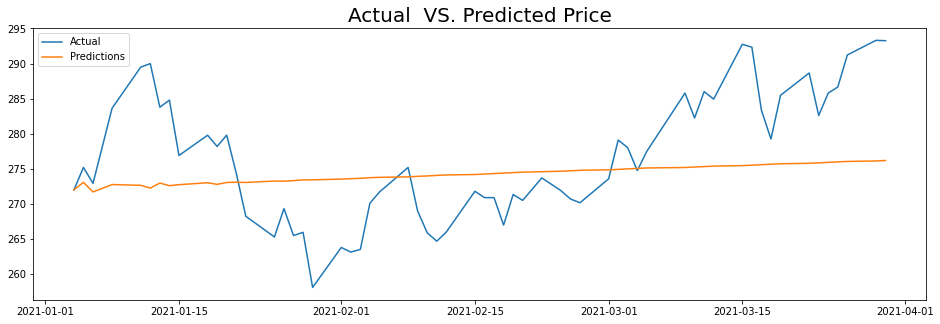

In [44]:
actual_prediction_plot(test_rus['Price'], test_new['Pred'])

In [45]:
mse = mean_squared_error(test_rus['Price'], test_new['Pred'])
print('MSE: '+str(mse))
mae = mean_absolute_error(test_rus['Price'], test_new['Pred'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_rus['Price'], test_new['Pred']))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(test_new['Pred'] - test_rus['Price'])/np.abs(test_rus['Price']))
print('MAPE: '+str(mape))

MSE: 96.20498770262476
MAE: 8.042860350399748
RMSE: 9.8084141278101
MAPE: 0.0263220080339296


In [46]:
#arimax


In [47]:
df1_russia=df_russia.copy().sort_index()
df1_russia.head()

,Price,Open,High,Low,Volume,Change %,diff_1
Date,,,,,,,
2020-01-03,255.00,255.99,258.19,253.70,35.85,0.0010,1.10
2020-01-06,253.90,254.75,254.84,251.40,22.35,-0.0043,-5.25
2020-01-08,259.15,253.57,259.15,253.03,40.82,0.0207,1.16
2020-01-09,257.99,259.40,261.76,257.01,38.33,-0.0045,-0.20
2020-01-10,258.19,257.86,259.25,256.88,18.85,0.0008,-4.21


In [48]:
df1_russia.reset_index(inplace=True)
df1_russia.head()

,Date,Price,Open,High,Low,Volume,Change %,diff_1
0,2020-01-03,255.00,255.99,258.19,253.70,35.85,0.0010,1.10
1,2020-01-06,253.90,254.75,254.84,251.40,22.35,-0.0043,-5.25
2,2020-01-08,259.15,253.57,259.15,253.03,40.82,0.0207,1.16
3,2020-01-09,257.99,259.40,261.76,257.01,38.33,-0.0045,-0.20
4,2020-01-10,258.19,257.86,259.25,256.88,18.85,0.0008,-4.21


In [49]:
def add_exogenous_features(df):
    #df.reset_index(inplace=True)
    # the chosen columns
    
    lag_features = ['Open', 'High', 'Low', 'Volume', 'Change %']
    
    # choose the mean, std days
    window1 = 3
    window2 = 7
    window3 = 30
    
    # rolling
    df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
    df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
    df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)
    
    # find the mean
    df_mean_3d = df_rolled_3d.mean().shift(1).reset_index()
    df_mean_7d = df_rolled_7d.mean().shift(1).reset_index()
    df_mean_30d = df_rolled_30d.mean().shift(1).reset_index()

    # fins the std
    df_std_3d = df_rolled_3d.std().shift(1).reset_index()
    df_std_7d = df_rolled_7d.std().shift(1).reset_index()
    df_std_30d = df_rolled_30d.std().shift(1).reset_index()

    # add the features to df
    for feature in lag_features:
        df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
        df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
        df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]

        df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
        df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
        df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]
    
    # remove the nulls
    df.fillna(df.mean(), inplace=True)
    #df.set_index("Date", drop=False, inplace=True)
    
    # add the other features
    df["month"] = df.Date.dt.month
    df["week"] = df.Date.dt.week
    df["day"] = df.Date.dt.day
    df["day_of_week"] = df.Date.dt.dayofweek
    return df

In [50]:
df = add_exogenous_features(df1_russia)

<ipython-input-49-521b87942686>:38: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df.fillna(df.mean(), inplace=True)
<ipython-input-49-521b87942686>:43: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["week"] = df.Date.dt.week


In [51]:
df1_russia.head()

,Date,Price,Open,High,Low,Volume,Change %,diff_1,Open_mean_lag3,Open_mean_lag7,...,Change %_mean_lag3,Change %_mean_lag7,Change %_mean_lag30,Change %_std_lag3,Change %_std_lag7,Change %_std_lag30,month,week,day,day_of_week
0,2020-01-03,255.00,255.99,258.19,253.70,35.85,0.0010,1.10,234.105118,233.895132,...,0.000688,0.000664,0.000642,0.016996,0.018436,0.019743,1,1,3,4
1,2020-01-06,253.90,254.75,254.84,251.40,22.35,-0.0043,-5.25,255.990000,255.990000,...,0.001000,0.001000,0.001000,0.016996,0.018436,0.019743,1,2,6,0
2,2020-01-08,259.15,253.57,259.15,253.03,40.82,0.0207,1.16,255.370000,255.370000,...,-0.001650,-0.001650,-0.001650,0.003748,0.003748,0.003748,1,2,8,2
3,2020-01-09,257.99,259.40,261.76,257.01,38.33,-0.0045,-0.20,254.770000,254.770000,...,0.005800,0.005800,0.005800,0.013173,0.013173,0.013173,1,2,9,3
4,2020-01-10,258.19,257.86,259.25,256.88,18.85,0.0008,-4.21,255.906667,255.927500,...,0.003967,0.003225,0.003225,0.014492,0.011925,0.011925,1,2,10,4


In [52]:
df1_russia.set_index("Date", drop=True, inplace=True)
df1_russia.head()

,Price,Open,High,Low,Volume,Change %,diff_1,Open_mean_lag3,Open_mean_lag7,Open_mean_lag30,...,Change %_mean_lag3,Change %_mean_lag7,Change %_mean_lag30,Change %_std_lag3,Change %_std_lag7,Change %_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,255.00,255.99,258.19,253.70,35.85,0.0010,1.10,234.105118,233.895132,232.985496,...,0.000688,0.000664,0.000642,0.016996,0.018436,0.019743,1,1,3,4
2020-01-06,253.90,254.75,254.84,251.40,22.35,-0.0043,-5.25,255.990000,255.990000,255.990000,...,0.001000,0.001000,0.001000,0.016996,0.018436,0.019743,1,2,6,0
2020-01-08,259.15,253.57,259.15,253.03,40.82,0.0207,1.16,255.370000,255.370000,255.370000,...,-0.001650,-0.001650,-0.001650,0.003748,0.003748,0.003748,1,2,8,2
2020-01-09,257.99,259.40,261.76,257.01,38.33,-0.0045,-0.20,254.770000,254.770000,254.770000,...,0.005800,0.005800,0.005800,0.013173,0.013173,0.013173,1,2,9,3
2020-01-10,258.19,257.86,259.25,256.88,18.85,0.0008,-4.21,255.906667,255.927500,255.927500,...,0.003967,0.003225,0.003225,0.014492,0.011925,0.011925,1,2,10,4


In [53]:
#select exogenous features
exogenous_features=df1_russia.columns[7:].values.tolist()
exogenous_features

['Open_mean_lag3',
 'Open_mean_lag7',
 'Open_mean_lag30',
 'Open_std_lag3',
 'Open_std_lag7',
 'Open_std_lag30',
 'High_mean_lag3',
 'High_mean_lag7',
 'High_mean_lag30',
 'High_std_lag3',
 'High_std_lag7',
 'High_std_lag30',
 'Low_mean_lag3',
 'Low_mean_lag7',
 'Low_mean_lag30',
 'Low_std_lag3',
 'Low_std_lag7',
 'Low_std_lag30',
 'Volume_mean_lag3',
 'Volume_mean_lag7',
 'Volume_mean_lag30',
 'Volume_std_lag3',
 'Volume_std_lag7',
 'Volume_std_lag30',
 'Change %_mean_lag3',
 'Change %_mean_lag7',
 'Change %_mean_lag30',
 'Change %_std_lag3',
 'Change %_std_lag7',
 'Change %_std_lag30',
 'month',
 'week',
 'day',
 'day_of_week']

In [54]:
#split data into train and test
train_ARMX = df1_russia[df1_russia.index < pd.to_datetime('2021-01-01', format="%Y-%m-%d")]
train_ARMX=train_ARMX.dropna()
test_ARMX=df1_russia[df1_russia.index >= pd.to_datetime('2021-01-01', format="%Y-%m-%d")]
test_ARMX=test_ARMX.dropna()

In [55]:
print('shape of train set: ',train_ARMX.shape)
print('shape of test set: ',test_ARMX.shape)

shape of train set:  (250, 41)
shape of test set:  (61, 41)


In [56]:
sorted_train = train_ARMX.sort_index()

In [57]:
sorted_train

,Price,Open,High,Low,Volume,Change %,diff_1,Open_mean_lag3,Open_mean_lag7,Open_mean_lag30,...,Change %_mean_lag3,Change %_mean_lag7,Change %_mean_lag30,Change %_std_lag3,Change %_std_lag7,Change %_std_lag30,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,255.00,255.99,258.19,253.70,35.85,0.0010,1.10,234.105118,233.895132,232.985496,...,0.000688,0.000664,0.000642,0.016996,0.018436,0.019743,1,1,3,4
2020-01-06,253.90,254.75,254.84,251.40,22.35,-0.0043,-5.25,255.990000,255.990000,255.990000,...,0.001000,0.001000,0.001000,0.016996,0.018436,0.019743,1,2,6,0
2020-01-08,259.15,253.57,259.15,253.03,40.82,0.0207,1.16,255.370000,255.370000,255.370000,...,-0.001650,-0.001650,-0.001650,0.003748,0.003748,0.003748,1,2,8,2
2020-01-09,257.99,259.40,261.76,257.01,38.33,-0.0045,-0.20,254.770000,254.770000,254.770000,...,0.005800,0.005800,0.005800,0.013173,0.013173,0.013173,1,2,9,3
2020-01-10,258.19,257.86,259.25,256.88,18.85,0.0008,-4.21,255.906667,255.927500,255.927500,...,0.003967,0.003225,0.003225,0.014492,0.011925,0.011925,1,2,10,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,269.32,271.98,272.82,267.13,42.61,-0.0029,-1.32,262.666667,271.651429,259.750333,...,0.000267,-0.004914,0.003510,0.030907,0.021047,0.017177,12,52,24,3
2020-12-25,270.64,269.97,271.00,268.28,11.99,0.0049,-4.06,264.593333,270.715714,260.706000,...,0.009633,-0.004686,0.003703,0.018434,0.021061,0.017067,12,52,25,4
2020-12-28,274.70,270.90,275.19,269.73,39.04,0.0150,2.70,268.066667,269.568571,261.638000,...,0.010933,-0.003800,0.003740,0.017642,0.021355,0.017069,12,53,28,0


In [58]:
#arimax_model = pm.auto_arima(sorted_train['Price'], exogenous=sorted_train[exogenous_features], trace=False, error_action="ignore", 
#                                 suppress_warnings=True)

In [59]:
#arimax_model.fit(sorted_train.Price, exogenous=sorted_train[exogenous_features])

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [70]:
sorted_train.Price

Date
2020-01-03    255.00
2020-01-06    253.90
2020-01-08    259.15
2020-01-09    257.99
2020-01-10    258.19
               ...  
2020-12-24    269.32
2020-12-25    270.64
2020-12-28    274.70
2020-12-29    272.00
2020-12-30    271.65
Name: Price, Length: 250, dtype: float64

In [61]:
# create the ARIMAX model
model_ARMX = auto_arima(sorted_train.Price, exogenous=sorted_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1499.638, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1501.228, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1501.180, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1497.685, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1502.372, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.611 seconds


In [62]:
model_ARMX.fit(sorted_train.Price, exogenous=sorted_train[exogenous_features])

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [63]:
#get predicted prices
y_pred_ARMX = model_ARMX.predict(n_periods=len(test_ARMX['Price']), exogenous=test_ARMX[exogenous_features])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [71]:
y_pred_ARMX

250    271.65
251    271.65
252    271.65
253    271.65
254    271.65
        ...  
306    271.65
307    271.65
308    271.65
309    271.65
310    271.65
Length: 61, dtype: float64

In [65]:
testARMX_new = test_ARMX.sort_index()

In [66]:
testARMX_new['Pred'] = y_pred_ARMX.values

In [67]:
testARMX_new.head()

,Price,Open,High,Low,Volume,Change %,diff_1,Open_mean_lag3,Open_mean_lag7,Open_mean_lag30,...,Change %_mean_lag7,Change %_mean_lag30,Change %_std_lag3,Change %_std_lag7,Change %_std_lag30,month,week,day,day_of_week,Pred
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,272.00,274.67,276.60,270.61,48.92,0.0013,-3.20,273.100000,269.007143,264.373333,...,0.005386,0.003897,0.012603,0.013551,0.016690,1,1,4,0,271.65
2021-01-05,275.20,272.69,275.70,270.28,45.58,0.0118,2.27,274.356667,271.167143,265.445667,...,0.005429,0.004277,0.005805,0.013535,0.016489,1,1,5,1,271.65
2021-01-06,272.93,275.94,275.94,271.62,40.95,-0.0082,-10.71,273.283333,272.658571,266.549333,...,0.002714,0.004787,0.006936,0.008607,0.016476,1,1,6,2,271.65
2021-01-08,283.64,275.11,283.99,275.11,88.93,0.0392,-5.85,274.433333,273.224286,267.732333,...,0.001957,0.004473,0.010004,0.009382,0.016636,1,1,8,4,271.65
2021-01-11,289.49,282.86,292.95,279.48,112.35,0.0206,-0.50,274.580000,273.958571,268.847667,...,0.006857,0.004720,0.023796,0.017022,0.017103,1,2,11,0,271.65


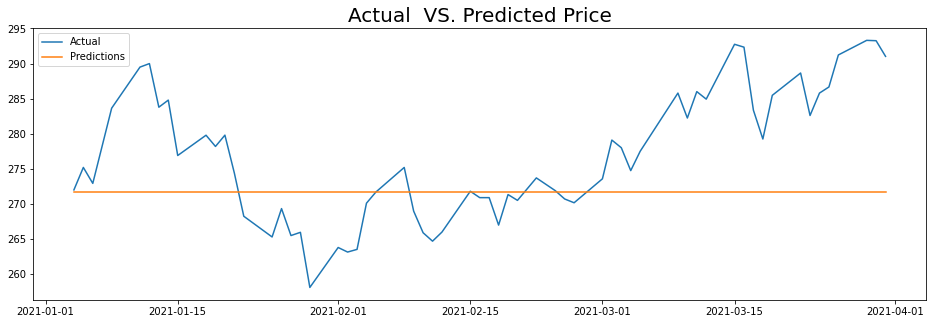

In [68]:
actual_prediction_plot(test_ARMX['Price'], testARMX_new['Pred'])

In [69]:
mse = mean_squared_error(test_ARMX['Price'], test_ARMX['Pred'])
print('MSE: '+str(mse))
mae = mean_absolute_error(test_ARMX['Price'], test_ARMX['Pred'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_ARMX['Price'], test_ARMX['Pred']))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(test_ARMX['Pred'] - test_ARMX['Price'])/np.abs(test_ARMX['Price']))
print('MAPE: '+str(mape))

KeyError: 'Pred'

In [ ]:
# As we can see Arima and Arimax models are not the best models for this data

In [ ]:
#FB Prophet

In [ ]:
df2_russia=df_russia.copy()
#df2_russia.set_index("Date", drop=False, inplace=True)
df2_russia.head()

In [ ]:
train_pro = df2_russia[df2_russia.index < pd.to_datetime('2021-01-01', format="%Y-%m-%d")]
train_pro=train_pro.dropna()
test_pro=df2_russia[df2_russia.index >= pd.to_datetime('2021-01-01', format="%Y-%m-%d")]
test_pro=test_pro.dropna()

In [ ]:
train_pro.reset_index(drop=False, inplace=True)
train_pro.head()


In [ ]:
train_pro = train_pro[["Date", "Price"]]
train_pro.rename(columns={"Date": "ds", "Price": "y"}, inplace=True)
#train_pro.set_index("ds", drop=True, inplace=True)
train_pro.head()

In [ ]:
test_pro.reset_index(drop=False, inplace=True)
test_pro.head()

In [ ]:
test_pro = test_pro[["Date", "Price"]]
test_pro.rename(columns={"Date": "ds", "Price": "y"}, inplace=True)
#test_pro.set_index("ds", drop=True, inplace=True)
test_pro.head()

In [ ]:
model = Prophet().fit(train_pro)

In [ ]:
forecast = model.predict(test_pro[['ds']])

In [ ]:
mae_pro = mean_absolute_error(test_pro.y, forecast.yhat)
mae_pro
mape_pro = np.mean(np.abs(test_pro.y - forecast.yhat)/np.abs(test_pro.y))
print('MAPE: '+str(mape_pro))

In [ ]:
actual_prediction_plot(test_pro.y, forecast.yhat)

In [ ]:
#Bollinger Bands

In [ ]:
df_bands=train_ARMX[['Price','Open']]

In [ ]:
period = 20
multiplier = 2

In [ ]:
df_bands['UpperBand'] = df_bands['Price'].rolling(period).mean() + df_bands['Price'].rolling(period).std() * multiplier
df_bands['LowerBand'] = df_bands['Price'].rolling(period).mean() - df_bands['Price'].rolling(period).std() * multiplier

In [ ]:
plt.rcParams['figure.figsize'] = [12, 7]

plt.rc('font', size=14)

plt.plot(df_bands['Price'], label = "Stock price values")
plt.plot(df_bands['UpperBand'], label = "Upper Bollinger Band")
plt.plot(df_bands['LowerBand'], label = "Lower Bollinger Band")

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
#Turkey dataset

In [ ]:
#xls = pd.ExcelFile('2020Q1Q2Q3Q4-2021Q1.xlsx')
#df_russia = pd.read_excel(xls, 'Russia - Sberbank Rossii PAO (S')
df_turkey = pd.read_excel(xls, 'Turkey - Koc Holding AS (KCHOL)')

In [ ]:
df_turkey.shape

In [ ]:
df_turkey.tail()

In [ ]:
#Rename the Vol. column to Volume
df_turkey.rename(columns = {'Vol.': 'Volume'}, inplace = True)

In [ ]:
#drop the last row
df_turkey.drop(index=df_turkey.index[-1], axis=0, inplace=True)
df_turkey["Volume"]=df_turkey.Volume.str.replace('M','')

In [ ]:
df_turkey["Date"]=pd.to_datetime(df_turkey.Date,format="%Y-%m-%d")

In [ ]:
df_turkey=df_turkey.astype({'Price':'float','Open':'float','High':'float','Low':'float','Volume':'float'})
print(df_turkey.dtypes)

In [ ]:
df_turkey.isnull().sum()

In [ ]:
plt.figure(figsize=(16,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_turkey['Date'],df_turkey['Price'])
plt.title('Turkey closing price')
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
df_close_turk = df_turkey['Price']
df_close_turk.plot(style='k.',kind='hist')
plt.title('Histogram of closing price')
plt.show()

In [ ]:
df_turkey.set_index("Date", inplace = True)
df_turkey.head()

In [ ]:
test_stationarity(df_turkey['Price'])

In [ ]:
#We see that the p-value is greater than 0.05 so we cannot reject the null hypothesis - that the time series is non-stationary and does have time-dependent structure. Also, the test statistics is greater than the critical values. so the data is non-stationary and does have time-dependent structure.

In [ ]:
df_turkey["diff_1"] = df_turkey.Price.diff(periods=1)
df_turkey.head()

In [ ]:
results_turk = adfuller(df_turkey["diff_1"].dropna())
print('The new p-value is:',results[1])

In [ ]:
#plot the new series
plt.figure(figsize=(16,6))
plt.title("The distribution of the new series")
df_turkey['diff_1'].plot()

In [ ]:
#plot rolling statistics
plt.figure(figsize=(15,7))
orig=plt.plot(df_turkey.diff_1, color='blue',label='Price')
R_mean=plt.plot(df_turkey.diff_1.rolling(7).mean(), color='red',label='rolling_mean')
R_std=plt.plot(df_turkey.diff_1.rolling(7).std(), color='black',label='rolling_std')
plt.legend(loc='best')
plt.title('Rolling mean & standard deviation for the new series')
plt.show(block='False')


In [ ]:
#split the data
train_turk = df_turkey[df_turkey.index < pd.to_datetime('2021-01-01', format="%Y-%m-%d")]
train_turk=train_turk.dropna()
test_turk=df_turkey[df_turkey.index >= pd.to_datetime('2021-01-01', format="%Y-%m-%d")]
test_turk=test_turk.dropna()

In [ ]:
arima_model_turk = pm.auto_arima(train_turk['Price'], start_p=1, start_q=1, test='adf', max_p=6, max_q=6, 
                      m=1, d=None, seasonal=False, start_P=0, D=1, trace=False, error_action='ignore',  
                      suppress_warnings=True, stepwise=False)

In [ ]:
y_pred_turk = arima_model_turk.predict(len(test_turk['Price']))

In [ ]:
test_turk['Pred'] = y_pred_turk.values

In [ ]:
test_turk.head()

In [ ]:
actual_prediction_plot(test_turk['Price'], test_turk['Pred'])

In [ ]:
mse = mean_squared_error(test_turk['Price'], test_turk['Pred'])
print('MSE: '+str(mse))
mae = mean_absolute_error(test_turk['Price'], test_turk['Pred'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_turk['Price'], test_turk['Pred']))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(test_turk['Pred'] - test_turk['Price'])/np.abs(test_turk['Price']))
print('MAPE: '+str(mape))

In [ ]:
#arimax

In [ ]:
df1_turkey=df_turkey.copy()
df1_turkey.head()

In [ ]:
df1_turkey.reset_index(inplace=True)
df1_turkey.head()

In [ ]:
df1 = add_exogenous_features(df1_turkey)

In [ ]:
df1_turkey.set_index("Date", drop=True, inplace=True)
df1_turkey.head()

In [ ]:
#select exogenous features
exogenous_features_turk=df1_turkey.columns[7:].values.tolist()
exogenous_features_turk

In [ ]:
#split data into train and test
train_ARMX_turk = df1_turkey[df1_turkey.index < pd.to_datetime('2021-01-01', format="%Y-%m-%d")]
train_ARMX_turk = train_ARMX_turk.dropna()
test_ARMX_turk =df1_turkey[df1_turkey.index >= pd.to_datetime('2021-01-01', format="%Y-%m-%d")]
test_ARMX_turk =test_ARMX_turk.dropna()

In [ ]:
print('shape of train set: ',train_ARMX_turk.shape)
print('shape of test set: ',test_ARMX_turk.shape)

In [ ]:
arimax_model_turk = pm.auto_arima(train_ARMX_turk['Price'], exogenous=train_ARMX_turk[exogenous_features_turk], trace=False, error_action="ignore", 
                                 suppress_warnings=True)

In [ ]:
arimax_model_turk.fit(train_ARMX_turk.Price, exogenous=train_ARMX_turk[exogenous_features_turk])

In [ ]:
#get predicted prices
y_pred_ARMX_turk = arimax_model_turk.predict(n_periods=len(test_ARMX_turk['Price']), exogenous=test_ARMX_turk[exogenous_features_turk])

In [ ]:
test_ARMX_turk['Pred'] = y_pred_ARMX_turk.values

In [ ]:
actual_prediction_plot(test_ARMX_turk['Price'], test_ARMX_turk['Pred'])

In [ ]:
mse = mean_squared_error(test_ARMX_turk['Price'], test_ARMX_turk['Pred'])
print('MSE: '+str(mse))
mae = mean_absolute_error(test_ARMX_turk['Price'], test_ARMX_turk['Pred'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_ARMX_turk['Price'], test_ARMX_turk['Pred']))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(test_ARMX_turk['Pred'] - test_ARMX_turk['Price'])/np.abs(test_ARMX_turk['Price']))
print('MAPE: '+str(mape))

In [ ]:
#Prophet

In [ ]:
#Bollinger Bands